# LCLS Cu Injector Surrogate Model  (up to OTR2)

predict $\epsilon_x$, $\epsilon_y$, $\sigma_x$, $\sigma_y$, $\sigma_z$
from NN trained on IMPACT-T simulations


# Links to Sections

* [Initial model info](#init)

* [Build model functions](#build)

* [Model predict with simulation units](#predict)

* [Model predict with machine units](#predict_machine)

* [Model comparison with sim scans](#scan)

* [Model comparison with a corrplot](#meas)


* [Hessian Calc and Questions](#hess_start)

* [Model Hessian Calc Sim Scale](#hess_sim)

* [Model Hessian Calc Machine Scale](#hess_machine)



# Imports

In [48]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, Activation, GaussianNoise, Reshape,  Conv2D, UpSampling2D
from tensorflow.keras import regularizers, datasets, layers, models
from tensorflow.keras.losses import mse 
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import time
import sys, os
import pickle as pick
import pandas as pd
import json
import array
import random
from math import sqrt
import pickle

from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler

In [49]:
import numdifftools as nd

<a id="init"></a>
# Initial Info

In [50]:
PATH = ''
NAME = 'v3b_cnsga_'
screen ='OTR2'

In [51]:
with open(PATH+NAME+screen+'_list_dict.json') as json_file:
    json_names = json.load(json_file)

In [52]:
#inputs and outputs in raw data
output_names=json_names['out_'+screen+'_vars']
output_names

['n_particle',
 'mean_gamma',
 'sigma_gamma',
 'norm_emit_x',
 'norm_emit_y',
 'sigma_x',
 'sigma_y',
 'sigma_z',
 'sigma_px',
 'sigma_py',
 'sigma_pz',
 'mean_x',
 'mean_y',
 'mean_z',
 'mean_px',
 'mean_py',
 'mean_pz',
 'higher_order_energy_spread',
 'cov_x__px',
 'cov_z__pz',
 'cov_y__py',
 'archive']

In [53]:
input_names = json_names['input_vars']
input_names

['distgen:r_dist:sigma_xy:value',
 'distgen:t_dist:length:value',
 'distgen:total_charge:value',
 'SOL1:solenoid_field_scale',
 'CQ01:b1_gradient',
 'SQ01:b1_gradient',
 'L0A_scale:voltage',
 'L0A_phase:dtheta0_deg',
 'L0B_scale:voltage',
 'L0B_phase:dtheta0_deg']

In [54]:
#inputs and outputs model is  trained on
model_in_list = input_names
model_out_list =['sigma_x','sigma_y','sigma_z','norm_emit_x', 'norm_emit_y']

In [55]:
#note model input variable ranges:
input_mins =[ 2.29557814e-01,  3.00000088e+00,  2.50000000e+02,  2.21046414e-01,
       -9.99734982e-03, -9.99951710e-03,  5.80000000e+07, -2.49996808e+01,
        7.00000000e+07, -2.49941337e+01]

input_maxs= [4.99997494e-01, 1.19929210e+01, 2.50000000e+02, 2.52305929e-01,
       9.92647049e-03, 9.99267544e-03, 5.80000000e+07, 9.99658492e+00,
       7.00000000e+07, 9.99948470e+00]


In [56]:
#dictionary of location of variables in array
loc_in = {model_in_list[i]: np.arange(0,len(model_in_list))[i] for i in range(len(model_in_list))} 
loc_out = {model_out_list[i]: np.arange(0,len(model_out_list))[i] for i in range(len(model_out_list))} 

## Converting between machine PVs and impact 

Explanation on model inputs and how they relate to PVs:
https://github.com/slaclab/lcls-cu-inj-surrogate/blob/master/pv_mapping/cu_inj_impact.csv

In [57]:
#conversions between sim and machine: 
#sim units /factor = measured units
#measured units * factor = sim units

sol_sim_factor = 0.51427242
quad_sim_factor = -0.476190476 

In [58]:
#adding dictionary for this later...
# sim_val = PV_val*to_sim_factor(PV_name)

pv_to_sim_factor={'IRIS:LR20:130:CONFG_SEL': 0.3333333,
            'SOLN:IN20:121:BDES':0.51427242,
            'QUAD:IN20:121:BDES':-0.476190476,
            'QUAD:IN20:122:BDES':-0.476190476,
            'ACCL:IN20:300:L0A_PDES':1,
            'ACCL:IN20:400:L0B_PDES':1,
            'ACCL:IN20:300:L0A_ADES':1000000,
            'ACCL:IN20:400:L0B_ADES':1000000,
            'QUAD:IN20:361:BDES':-0.925925926,
            'QUAD:IN20:371:BDES':-0.925925926,
            'QUAD:IN20:425:BDES':-0.925925926,
            'QUAD:IN20:441:BDES':-0.925925926,
            'QUAD:IN20:511:BDES':-0.925925926,
            'QUAD:IN20:525:BDES':-0.925925926,
            'Charge':1, #check this
            'Pulse_length':1.65}
            
machine_unit ={'IRIS:LR20:130:CONFG_SEL': 'mm',
            'SOLN:IN20:121:BDES':'kG*m',
            'QUAD:IN20:121:BDES':'kG',
            'QUAD:IN20:122:BDES':'kG',
            'ACCL:IN20:300:L0A_PDES':'deg',
            'ACCL:IN20:400:L0B_PDES':'deg',
            'ACCL:IN20:300:L0A_ADES':'MV',
            'ACCL:IN20:400:L0B_ADES':'MV',
            'QUAD:IN20:361:BDES':'kG',
            'QUAD:IN20:371:BDES':'kG',
            'QUAD:IN20:425:BDES':'kG',
            'QUAD:IN20:441:BDES':'kG',
            'QUAD:IN20:511:BDES':'kG',
            'QUAD:IN20:525:BDES':'kG',
            'Pulse_length':'ps'}

pv_to_sim_name={'IRIS:LR20:130:CONFG_SEL': 'distgen:r_dist:sigma_xy:value',
            'SOLN:IN20:121:BDES':'SOL1:solenoid_field_scale',
            'QUAD:IN20:121:BDES':'CQ01:b1_gradient',
            'QUAD:IN20:122:BDES':'SQ01:b1_gradient',
            'ACCL:IN20:300:L0A_PDES':'L0A_phase:dtheta0_deg',
            'ACCL:IN20:400:L0B_PDES':'L0B_phase:dtheta0_deg',
            'ACCL:IN20:300:L0A_ADES':'L0A_scale:voltage',
            'ACCL:IN20:400:L0B_ADES':'L0B_scale:voltage',
            'QUAD:IN20:361:BDES':'QA01:b1_gradient',
            'QUAD:IN20:371:BDES':'QA02:b1_gradient',
            'QUAD:IN20:425:BDES':'QE01:b1_gradient',
            'QUAD:IN20:441:BDES':'QE02:b1_gradient',
            'QUAD:IN20:511:BDES':'QE03:b1_gradient',
            'QUAD:IN20:525:BDES':'QE04:b1_gradient',
            'Pulse_length':'distgen:t_dist:length:value',
            'Charge':'distgen:total_charge:value'} #check this PV

sim_name_to_pv_name={pv_to_sim_name[list(pv_to_sim_name.keys())[i]]:list(pv_to_sim_name.keys())[i] for i in range(0,len(list(pv_to_sim_name.keys())))}

In [59]:

#load scaler for transforming data before sending to NN
scalerfile = 'transformer_x.sav'
transformer_x = pickle.load(open(scalerfile, 'rb'))
scalerfile = 'transformer_y.sav'
transformer_y = pickle.load(open(scalerfile, 'rb'))

/sdf/home/e/edelen/miniconda3/envs/ml_nersc/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


<a id="build"></a>
# Define Model

In [60]:
# manual scaling
def build_ff_sc2sc(in_dim_scalar = 4, 
                               out_dim_scalar = 4,
                               l1 = 8, l2 = 6, l3 = 4, l4 = 4, l5 = 4,l6=10,l7=10,l8=10,l9=10, 
                               opt = 'adam', 
                               loss = 'mse', 
                               act = 'tanh', 
                               l2reg = 0.00000):
    
    
    layer_in = Input(shape=(in_dim_scalar,))
    layer_ = Dense(l1, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_in)
    layer_ = Dense(l2, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l3, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l4, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l5, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l6, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_) 
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l7, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dropout(0.05)(layer_)
    layer_ = Dense(l8, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_ = Dense(l9, activation=act, kernel_regularizer=regularizers.l2(l2reg))(layer_)
    layer_out = Dense(out_dim_scalar, activation='linear')(layer_)
    
    
    model = Model(inputs=layer_in, outputs=layer_out)
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    return model

In [61]:
MODEL_PATH = './'

In [62]:
MODEL_NAME = 'model_OTR_rms_emit'

In [63]:
model_1=load_model(MODEL_PATH + MODEL_NAME+'.h5')

In [64]:
savepath = MODEL_PATH +'figures/'



<a id="predict"></a>



# Model Predict Example -- Simulation Unit Inputs

In [65]:
#input and output are full scale values

def model_pred(x):
    
    x =  transformer_x.transform(x)
    y = model_1.predict(x)
    y = transformer_y.inverse_transform(y)
    
    return np.exp(y) #trained on log data

In [66]:
X_true = np.load('x_raw_small.npy')
Y_true = np.load('y_raw_small.npy')

In [67]:
# make predictions
Y_pred = model_pred(X_true)

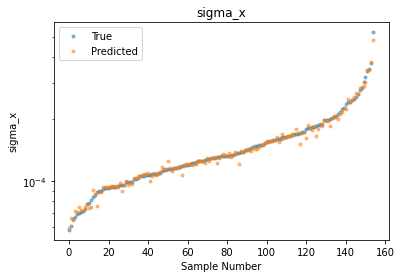

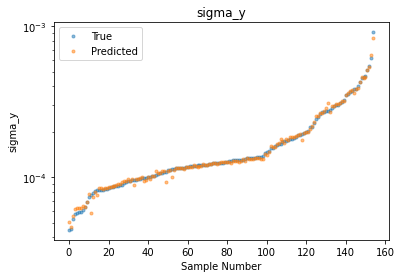

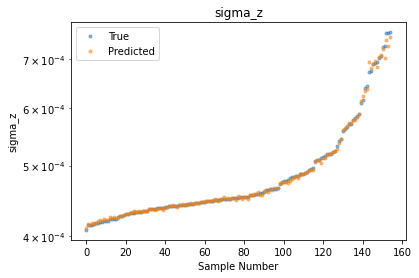

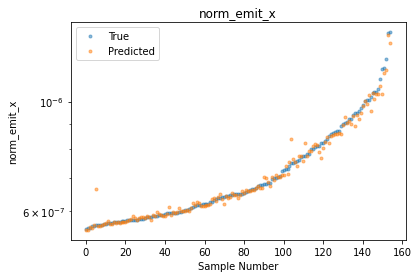

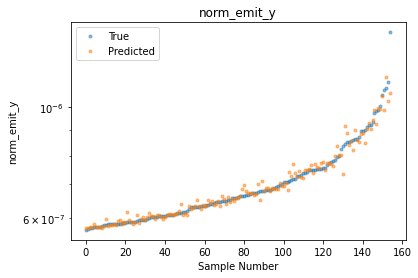

In [68]:
 for i in range(0,Y_true.shape[1]):
    idx=np.argsort(Y_true[:,i])
    plt.plot(Y_true[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred[idx,i],'.',alpha=0.5)
    plt.yscale('log')
    plt.title(model_out_list[i])
    plt.ylabel(model_out_list[i])
    plt.xlabel('Sample Number')
    plt.legend(['True','Predicted'])
    plt.show()

### load some nominally optimal points from simulation to run

In [69]:
scanlist=[
'scan_SOL1:solenoid_field_scale-fine2.json',
'scan_SQ01:b1_gradient-fine2.json',
'scan_CQ01:b1_gradient-fine2.json',]

#load from first scan
dat1 = json.load(open(PATH+scanlist[0]))
inputs=pd.DataFrame(dat1['inputs'])
outputs=pd.DataFrame(dat1['outputs'])

#select only model inputs and outputs
inputs = inputs[model_in_list];

#for this run looking at slightly z in simulation, model will be off a bit
model_out_list2=['end_'+s for s in model_out_list]

outputs = outputs[model_out_list2];

#select first row
ref_input_values = np.asarray(inputs[0:1])



In [70]:
# make predictions
Y_pred = model_pred(ref_input_values)

Y_pred

array([[5.0493726e-04, 8.3292002e-04, 4.5215926e-04, 1.1734467e-06,
        1.1347943e-06]], dtype=float32)

In [71]:
for out in model_out_list:
    print(out,' ', Y_pred[:,loc_out[out]])

sigma_x   [0.00050494]
sigma_y   [0.00083292]
sigma_z   [0.00045216]
norm_emit_x   [1.1734467e-06]
norm_emit_y   [1.1347943e-06]


### repeat for nominal running values

In [72]:
#nominal values for 2/18/2021 measured
pv_lrad = 1.2 #mm
pv_pl = 2 #ps
# charge 250 pc
# bunch length  600um --> 2ps 

In [73]:
#convert to sim 
print(pv_lrad*pv_to_sim_factor['IRIS:LR20:130:CONFG_SEL'])
print(pv_pl*pv_to_sim_factor['Pulse_length'] )#no real PV for this

0.39999996
3.3


In [74]:
pv_to_sim_factor['Pulse_length']

1.65

In [75]:
#copy nominal input values optimal from sim
md_values = pd.DataFrame.copy(inputs[0:1])

In [76]:
#check dictionaries
print(pv_to_sim_name['IRIS:LR20:130:CONFG_SEL'])
print(md_values['distgen:r_dist:sigma_xy:value'])

distgen:r_dist:sigma_xy:value
0    0.423868
Name: distgen:r_dist:sigma_xy:value, dtype: float64


In [77]:
md_values[:][pv_to_sim_name['Pulse_length']] = pv_pl*pv_to_sim_factor['Pulse_length']
md_values[:][pv_to_sim_name['IRIS:LR20:130:CONFG_SEL']] = pv_lrad*pv_to_sim_factor['IRIS:LR20:130:CONFG_SEL']

In [78]:
md_values

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,distgen:total_charge:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_scale:voltage,L0A_phase:dtheta0_deg,L0B_scale:voltage,L0B_phase:dtheta0_deg
0,0.4,3.3,250,0.22,0.000714,0.000327,58000000.0,-9.535973,70000000.0,9.855662


In [79]:
inputs[0:1]

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,distgen:total_charge:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_scale:voltage,L0A_phase:dtheta0_deg,L0B_scale:voltage,L0B_phase:dtheta0_deg
0,0.423868,3.060835,250,0.22,0.000714,0.000327,58000000.0,-9.535973,70000000.0,9.855662


In [80]:
# make predictions
#convert dataframe to array first
Y_pred = model_pred(np.asarray(md_values))

for out in model_out_list:
    print(out,' ', Y_pred[:,loc_out[out]])

sigma_x   [0.00050946]
sigma_y   [0.00083387]
sigma_z   [0.00046743]
norm_emit_x   [1.1716319e-06]
norm_emit_y   [1.1253212e-06]


<a id="predict_machine"></a>
# Model Predict with Machine Unit Inputs

In [81]:
def model_pred_machine_units(x,debug=False):
    
    #convert from machine units to sim units
    
    x_s = np.copy(x)
    for i in range(0,len(model_in_list)):
        x_s[:,loc_in[model_in_list[i]]]=x[:,loc_in[model_in_list[i]]]*pv_to_sim_factor[sim_name_to_pv_name[model_in_list[i]]]
        
    if debug:
        print('small scale units',x_s)
        
    #scale for NN pred
    x_s =  transformer_x.transform(x_s)
    y = model_1.predict(x_s)
    y = transformer_y.inverse_transform(y)
    #scale back to sim units (same as machine)
    
    return np.exp(y) #trained on log data

In [82]:
#Get some machine unit values
md_values_machine_scale = np.copy(np.asarray(md_values))
for i in range(0,len(model_in_list)):
    md_values_machine_scale[:,loc_in[model_in_list[i]]]=np.asarray(md_values)[:,loc_in[model_in_list[i]]]/pv_to_sim_factor[sim_name_to_pv_name[model_in_list[i]]]

In [83]:
md_values

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,distgen:total_charge:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_scale:voltage,L0A_phase:dtheta0_deg,L0B_scale:voltage,L0B_phase:dtheta0_deg
0,0.4,3.3,250,0.22,0.000714,0.000327,58000000.0,-9.535973,70000000.0,9.855662


In [84]:
md_values_machine_scale

array([[ 1.20000000e+00,  2.00000000e+00,  2.50000000e+02,
         4.27788836e-01, -1.49922712e-03, -6.87298943e-04,
         5.80000000e+01, -9.53597349e+00,  7.00000000e+01,
         9.85566222e+00]])

In [85]:
model_pred_machine_units(md_values_machine_scale, debug=True);

small scale units [[ 3.99999960e-01  3.30000000e+00  2.50000000e+02  2.20000000e-01
   7.13917676e-04  3.27285211e-04  5.80000000e+07 -9.53597349e+00
   7.00000000e+07  9.85566222e+00]]


### showing works

In [86]:
i=3

In [87]:
pv_to_sim_factor[sim_name_to_pv_name[model_in_list[i]]]

0.51427242

In [88]:
np.asarray(md_values)[:,loc_in[model_in_list[i]]]/pv_to_sim_factor[sim_name_to_pv_name[model_in_list[i]]]

array([0.42778884])

In [89]:
md_values_machine_scale

array([[ 1.20000000e+00,  2.00000000e+00,  2.50000000e+02,
         4.27788836e-01, -1.49922712e-03, -6.87298943e-04,
         5.80000000e+01, -9.53597349e+00,  7.00000000e+01,
         9.85566222e+00]])

### make sure have same output

In [90]:
model_pred(np.concatenate((np.asarray(md_values),np.asarray(md_values)),axis=0))

array([[5.0945790e-04, 8.3387148e-04, 4.6742996e-04, 1.1716319e-06,
        1.1253212e-06],
       [5.0945790e-04, 8.3387148e-04, 4.6742996e-04, 1.1716319e-06,
        1.1253212e-06]], dtype=float32)

In [91]:
model_pred(np.asarray(md_values))

array([[5.0945813e-04, 8.3387108e-04, 4.6742996e-04, 1.1716319e-06,
        1.1253212e-06]], dtype=float32)

In [92]:
model_pred_machine_units(np.concatenate((md_values_machine_scale,md_values_machine_scale),axis=0))

array([[5.0945790e-04, 8.3387148e-04, 4.6742996e-04, 1.1716319e-06,
        1.1253212e-06],
       [5.0945790e-04, 8.3387148e-04, 4.6742996e-04, 1.1716319e-06,
        1.1253212e-06]], dtype=float32)

In [93]:
model_pred_machine_units(md_values_machine_scale)

array([[5.0945813e-04, 8.3387108e-04, 4.6742996e-04, 1.1716319e-06,
        1.1253212e-06]], dtype=float32)

In [94]:
# these are the same



<a id="scan"></a>



# Compare with 1-D Scans from Simulation Around Optimum 
### (likely not well-sampled in training)

In [95]:
# run a scan using scanlist at OTR2-- (TODO later should be a clean, separate general scan function )

def do_scan_at_OTR2(numscan=100,scanpath = '/gpfs/slac/staas/fs1/g/accelerator_modeling/edelen/LCLS_CU_full/sims/scan/'):
    
    scan_idx={'SOL1:solenoid_field':[0,32],'SQ01:b1_gradient':[32,64],'CQ01:b1_gradient':[64,96]}

    outputs = np.load(scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

    inputs = np.load(scanpath+'scan_scalar_in.npy',allow_pickle=True)

    inputs=pd.DataFrame(inputs,columns=input_names)

    outputs=pd.DataFrame(outputs,columns=output_names)
        
    print(' ')
    print('SOL1:solenoid_field_scale')
    print(' ')  
    
    FIGNAME= 'SOL_'


    inputs = inputs[scan_idx['SOL1:solenoid_field'][0]:scan_idx['SOL1:solenoid_field'][1]][model_in_list];


    outputs = outputs[scan_idx['SOL1:solenoid_field'][0]:scan_idx['SOL1:solenoid_field'][1]][model_out_list];
    scan = np.linspace(0.01,1,numscan)
    
    mine = 5.461418942827289e-07
    
    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])
    
    x_scan=transformer_x.transform(x_raw_scan)
    
    x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan
    
    Y_pred_scalar = model_1.predict(x_scan)
    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)
    
    x_scan2=transformer_x.transform(inputs)
    
    Y_pred_scalar2 = model_1.predict(x_scan2)
    
    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emit_x.png',bbox_inches='tight')
    plt.show()
    
    
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emit_y.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    plt.ylim([0.43,0.51])
    plt.show()
    
    
    print(' ')
    print('SQ01:b1_gradient')
    print(' ')  
    


    FIGNAME= 'SQ01_'

    outputs = np.load(scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

    inputs = np.load(scanpath+'scan_scalar_in.npy',allow_pickle=True)

    inputs=pd.DataFrame(inputs,columns=input_names)

    outputs=pd.DataFrame(outputs,columns=output_names)
        
    inputs = inputs[scan_idx['SQ01:b1_gradient'][0]:scan_idx['SQ01:b1_gradient'][1]][model_in_list];


    outputs = outputs[scan_idx['SQ01:b1_gradient'][0]:scan_idx['SQ01:b1_gradient'][1]][model_out_list];


    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['SQ01:b1_gradient']]=scan



    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)

    x_scan2=transformer_x.transform(inputs)

    Y_pred_scalar2 = model_1.predict(x_scan2)

    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([0.45,0.49])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    #plt.ylim([mine*10**,1])
    plt.show()
    
    print(' ')
    print('CQ01:b1_gradient')
    print(' ')  
    

    FIGNAME = 'CQ10_'

    outputs = np.load(scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

    inputs = np.load(scanpath+'scan_scalar_in.npy',allow_pickle=True)

    inputs=pd.DataFrame(inputs,columns=input_names)

    outputs=pd.DataFrame(outputs,columns=output_names)
        
    inputs = inputs[scan_idx['CQ01:b1_gradient'][0]:scan_idx['CQ01:b1_gradient'][1]][model_in_list];


    outputs = outputs[scan_idx['CQ01:b1_gradient'][0]:scan_idx['CQ01:b1_gradient'][1]][model_out_list];


    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['CQ01:b1_gradient']]=scan



    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)



    x_scan2=transformer_x.transform(inputs)

    Y_pred_scalar2 = model_1.predict(x_scan2)

    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)

    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])

    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()    


    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([0.45,0.49])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')

    #plt.ylim([mine*10**,1])
    plt.show()

    return


 
SOL1:solenoid_field_scale
 


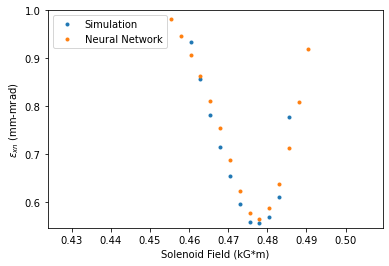

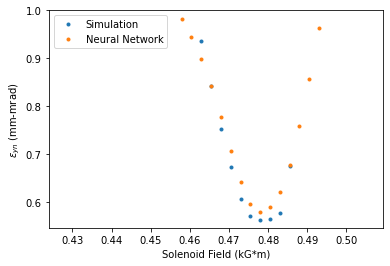

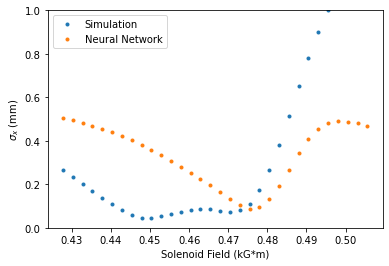

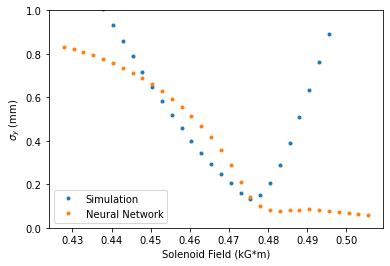

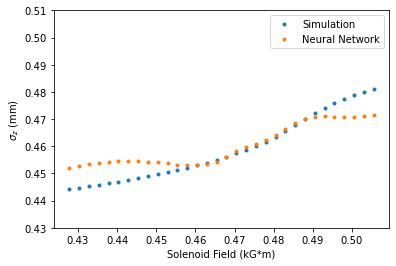

 
SQ01:b1_gradient
 


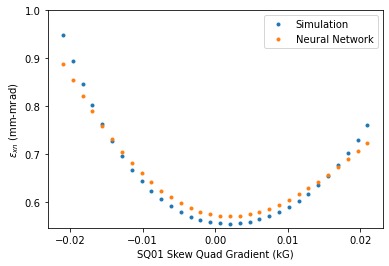

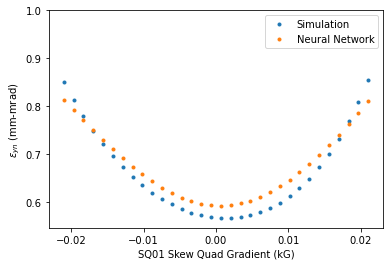

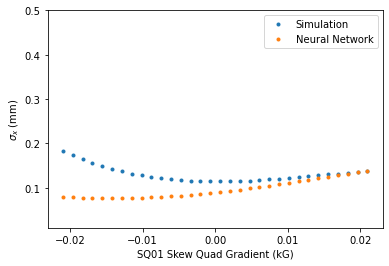

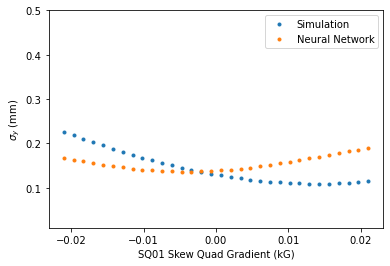

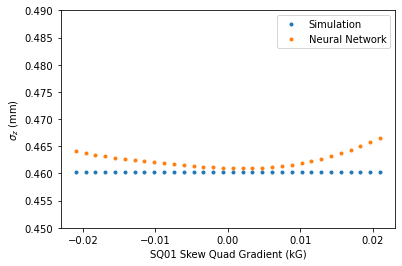

 
CQ01:b1_gradient
 


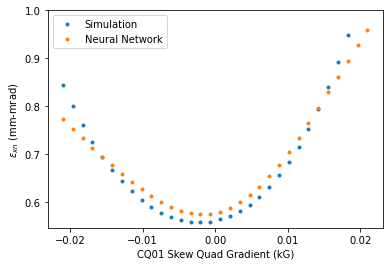

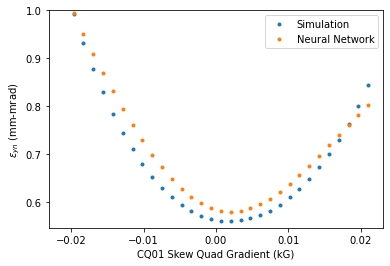

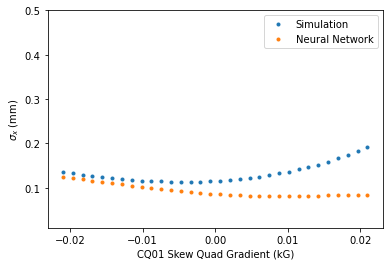

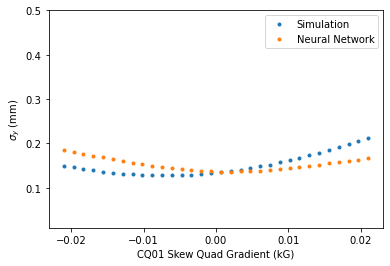

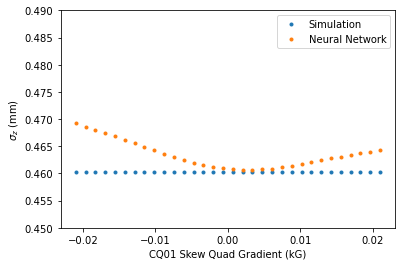

In [96]:
do_scan_at_OTR2()

In [97]:
# run a scan using scanlist at end of sim (z=16m) -- (TODO later should be a clean, separate general scan function )

def do_scan_at_z16m(numscan=100, scanlist=[
'scan_SOL1:solenoid_field_scale-fine2.json',
'scan_SQ01:b1_gradient-fine2.json',
'scan_CQ01:b1_gradient-fine2.json',]):
    
    
        
    print(' ')
    print('SOL1:solenoid_field_scale')
    print(' ')  
    
    FIGNAME= 'SOL_'
    dat1 = json.load(open(PATH+scanlist[0]))
    inputs=pd.DataFrame(dat1['inputs'])
    outputs=pd.DataFrame(dat1['outputs'])

    inputs = inputs[model_in_list];

    model_out_list2=['end_'+s for s in model_out_list]

    outputs = outputs[model_out_list2];
    scan = np.linspace(0.01,1,numscan)
    
    mine = 5.461418942827289e-07
    
    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])
    
    x_scan=transformer_x.transform(x_raw_scan)
    
    x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan
    
    Y_pred_scalar = model_1.predict(x_scan)
    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)
    
    x_scan2=transformer_x.transform(inputs)
    
    Y_pred_scalar2 = model_1.predict(x_scan2)
    
    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emit_x.png',bbox_inches='tight')
    plt.show()
    
    
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emit_y.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SOL1:solenoid_field_scale']/0.51427242,outputs['end_sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    plt.ylim([0.43,0.51])
    plt.show()
    
    
    print(' ')
    print('SQ01:b1_gradient')
    print(' ')  
    
    dat1 = json.load(open(PATH+scanlist[1]))

    FIGNAME= 'SQ01_'

    inputs=pd.DataFrame(dat1['inputs'])
    outputs=pd.DataFrame(dat1['outputs'])

    inputs = inputs[model_in_list];

    model_out_list2=['end_'+s for s in model_out_list]

    outputs = outputs[model_out_list2];

    #Scans
    numscan=100
    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['SQ01:b1_gradient']]=scan



    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)

    x_scan2=transformer_x.transform(inputs)

    Y_pred_scalar2 = model_1.predict(x_scan2)

    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['SQ01:b1_gradient']/-0.476190476,outputs['end_sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([0.45,0.49])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    #plt.ylim([mine*10**,1])
    plt.show()
    
    print(' ')
    print('CQ01:b1_gradient')
    print(' ')  
    
    dat1 = json.load(open(PATH+scanlist[2]))

    FIGNAME = 'CQ10_'

    inputs=pd.DataFrame(dat1['inputs'])
    outputs=pd.DataFrame(dat1['outputs'])

    inputs = inputs[model_in_list];

    model_out_list2=['end_'+s for s in model_out_list]

    outputs = outputs[model_out_list2];

    #Scans
    numscan=100
    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['CQ01:b1_gradient']]=scan



    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)



    x_scan2=transformer_x.transform(inputs)

    Y_pred_scalar2 = model_1.predict(x_scan2)

    Y_pred2 = np.exp(transformer_y.inverse_transform(Y_pred_scalar2))
    X_scan2 = transformer_x.inverse_transform(x_scan2)

    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_norm_emit_x']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylim([mine*10**6,1])
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()

    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_norm_emit_y']*10**6,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])

    plt.ylim([mine*10**6,1])
    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_sigma_x']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_sigma_y']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.01,0.5])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Simulation','Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()    


    plt.plot(inputs['CQ01:b1_gradient']/-0.476190476,outputs['end_sigma_z']*10**3,'.')
    plt.plot(X_scan2[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred2[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Simulation','Neural Network'])
    plt.ylim([0.45,0.49])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')

    #plt.ylim([mine*10**,1])
    plt.show()

    return


 
SOL1:solenoid_field_scale
 


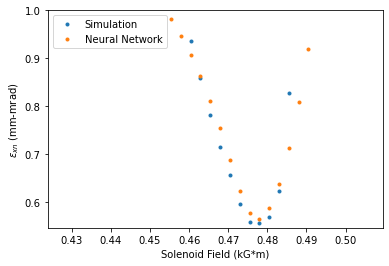

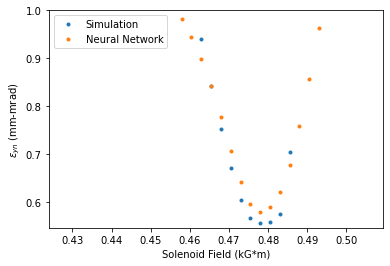

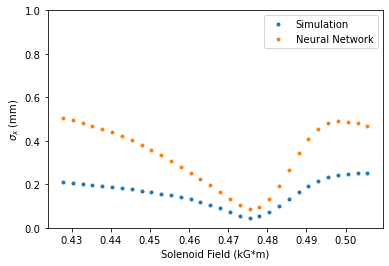

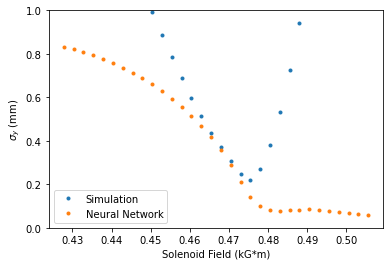

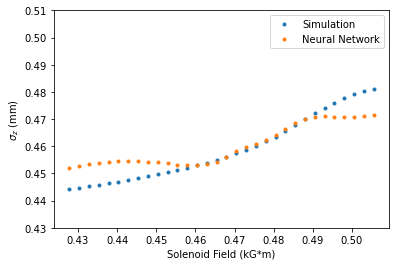

 
SQ01:b1_gradient
 


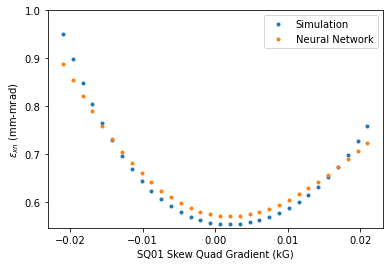

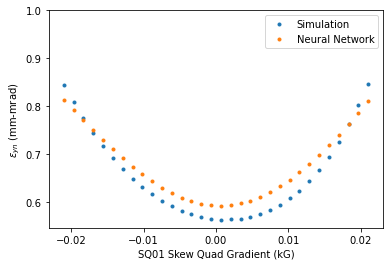

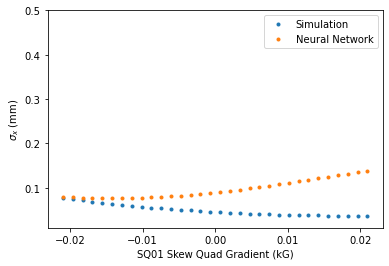

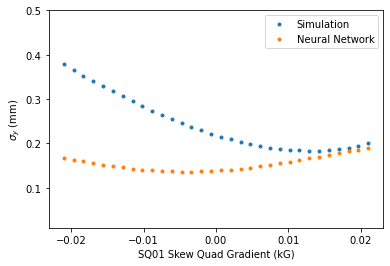

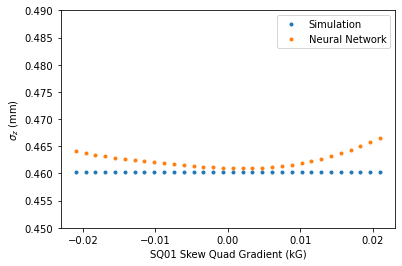

 
CQ01:b1_gradient
 


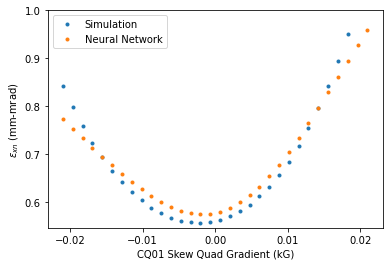

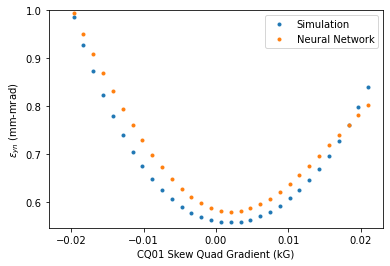

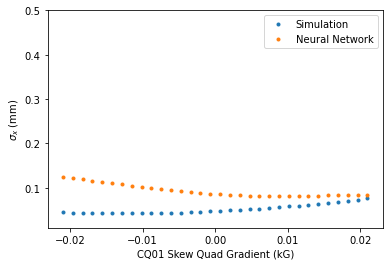

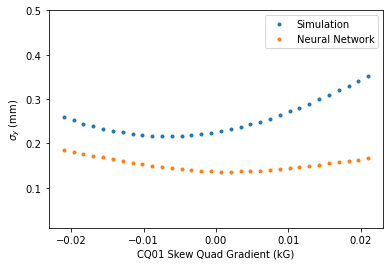

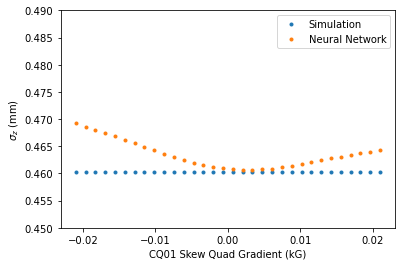

In [98]:
 do_scan_at_z16m(numscan=100, scanlist=[
'scan_SOL1:solenoid_field_scale-fine2.json',
'scan_SQ01:b1_gradient-fine2.json',
'scan_CQ01:b1_gradient-fine2.json',])



<a id="meas"></a>


# Comparison with some measured data 
(note guessing on some of these inputs other than SQ/CQ/SOL, so not expected to be exact)

In [99]:
emitx=[1.4085,1.4305,1.0905, 0.7137,0.5358, 0.5075,0.6359,1.1666,2.4465]
emity=[2.5192, 1.7998, 0.6448, 0.6579, 0.5244, 0.5686, 0, 2.5051, 11.7213]

In [100]:
#CQ and SQ and SO
c=-0.0024
s=0
sol=np.asarray([0.440000000000000,0.445000000000000,
                0.450000000000000,0.455000000000000,
                0.460000000000000,0.465000000000000,
                0.470000000000000,0.475000000000000,0.480000000000000])

(4e-07, 3.0)

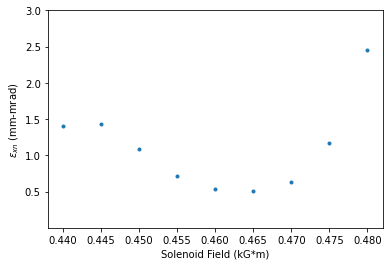

In [101]:
plt.plot(sol,emitx,'.')
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([4e-7,3])

(4e-07, 5.0)

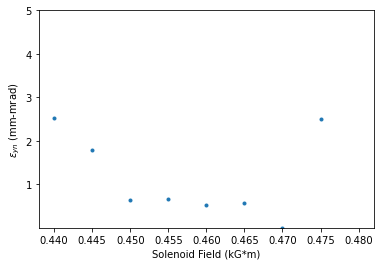

In [102]:
plt.plot(sol,emity,'.')
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([4e-7,5])

In [103]:
#get some inputs for other values
numscan=100
#dat1 = json.load(open(PATH+'scan_SOL1:solenoid_field_scale-fine2.json'))
#inputs=pd.DataFrame(dat1['inputs'])
#outputs=pd.DataFrame(dat1['outputs'])
#inputs = inputs[model_in_list];
#model_out_list2=['end_'+s for s in model_out_list]
#outputs = outputs[model_out_list2];



In [104]:
#get scan data

scanpath = ''

scan_idx={'SOL1:solenoid_field':[0,32],'SQ01:b1_gradient':[32,64],'CQ01:b1_gradient':[64,96]}

outputs = np.load(scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

inputs = np.load(scanpath+'scan_scalar_in.npy',allow_pickle=True)

inputs=pd.DataFrame(inputs,columns=input_names)

outputs=pd.DataFrame(outputs,columns=output_names)


inputs = inputs[scan_idx['SOL1:solenoid_field'][0]:scan_idx['SOL1:solenoid_field'][1]][model_in_list];


outputs = outputs[scan_idx['SOL1:solenoid_field'][0]:scan_idx['SOL1:solenoid_field'][1]][model_out_list];

mine = 5.461418942827289e-07
x_raw_scan=np.empty((numscan,len(model_in_list)))
x_raw_scan[:,:]=np.asarray(inputs[0:1])

scan = np.linspace(0.01,1.2,numscan)

x_raw_scan=np.empty((numscan,len(model_in_list)))
x_raw_scan[:,:]=np.asarray(inputs[0:1])

x_raw_scan[:,loc_in['CQ01:b1_gradient']]=c*quad_sim_factor

x_raw_scan[:,loc_in['SQ01:b1_gradient']]=s*quad_sim_factor

x_scan=transformer_x.transform(x_raw_scan)

x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan


In [105]:
Y_pred_scalar = model_1.predict(x_scan)
Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
X_scan = transformer_x.inverse_transform(x_scan)

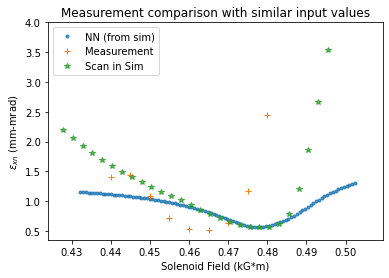

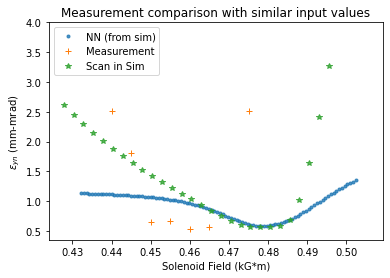

In [106]:
plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_x']]*10**6,'.',alpha=0.8);
plt.plot(sol,emitx,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_x']*10**6,'*',alpha=0.8)
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,4])
plt.legend(['NN (from sim)','Measurement','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()

plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_y']]*10**6,'.',alpha=0.8);
plt.plot(sol,emity,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_y']*10**6,'*',alpha=0.8)
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,4])
plt.legend(['NN (from sim)','Measurement','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()

## zoom in

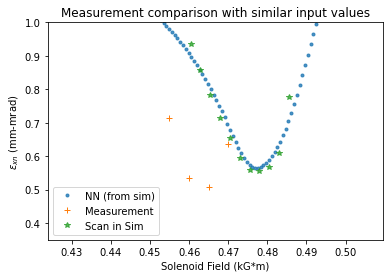

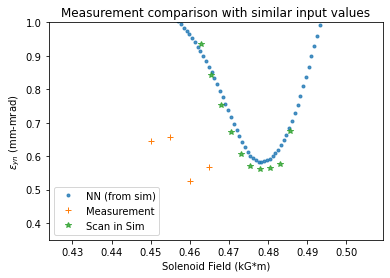

In [107]:
plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_x']]*10**6,'.',alpha=0.8);
plt.plot(sol,emitx,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_x']*10**6,'*',alpha=0.8)
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,1])
plt.legend(['NN (from sim)','Measurement','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()

plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_y']]*10**6,'.',alpha=0.8);
plt.plot(sol,emity,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_y']*10**6,'*',alpha=0.8)
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,1])
plt.legend(['NN (from sim)','Measurement','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()

## Repeat at nominal MD laser radius

In [108]:
scan = np.linspace(0.01,1,numscan)

x_raw_scan3=np.empty((numscan,len(model_in_list)))
x_raw_scan3[:,:]=np.asarray(md_values[0:1])

x_scan3=transformer_x.transform(x_raw_scan3)

x_raw_scan3[:,loc_in['CQ01:b1_gradient']]=c*quad_sim_factor

x_raw_scan3[:,loc_in['SQ01:b1_gradient']]=s*quad_sim_factor

x_scan3=transformer_x.transform(x_raw_scan3)

x_scan3[:,loc_in['SOL1:solenoid_field_scale']]=scan

Y_pred_scalar3 = model_1.predict(x_scan3)
Y_pred3 = np.exp(transformer_y.inverse_transform(Y_pred_scalar3))
X_scan3 = transformer_x.inverse_transform(x_scan3)

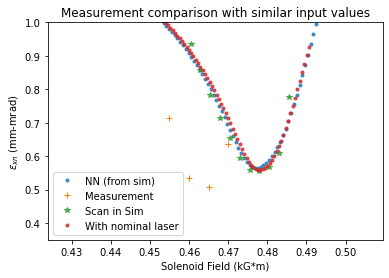

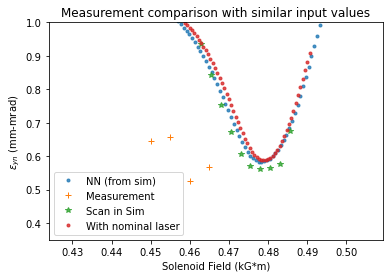

In [109]:
plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_x']]*10**6,'.',alpha=0.8);
plt.plot(sol,emitx,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_x']*10**6,'*',alpha=0.8)
plt.plot(X_scan3[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred3[:,loc_out['norm_emit_x']]*10**6,'.',alpha=0.8);
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,1])
plt.legend(['NN (from sim)','Measurement','Scan in Sim','With nominal laser'])
plt.title("Measurement comparison with similar input values")
plt.show()

plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_y']]*10**6,'.',alpha=0.8);
plt.plot(sol,emity,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_y']*10**6,'*',alpha=0.8)
plt.plot(X_scan3[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred3[:,loc_out['norm_emit_y']]*10**6,'.',alpha=0.8);
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,1])
plt.legend(['NN (from sim)','Measurement','Scan in Sim','With nominal laser'])
plt.title("Measurement comparison with similar input values")
plt.show()

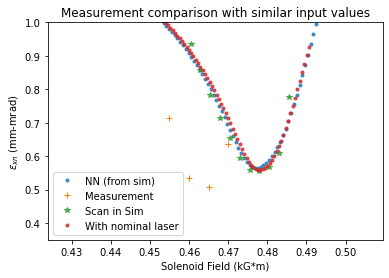

In [110]:
plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred[:,loc_out['norm_emit_x']]*10**6,'.',alpha=0.8);
plt.plot(sol,emitx,'+')
plt.plot(inputs['SOL1:solenoid_field_scale']/sol_sim_factor,outputs['norm_emit_x']*10**6,'*',alpha=0.8)
plt.plot(X_scan3[:,loc_in['SOL1:solenoid_field_scale']]/sol_sim_factor,Y_pred3[:,loc_out['norm_emit_x']]*10**6,'.',alpha=0.8);
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([0.35,1])
plt.legend(['NN (from sim)','Measurement','Scan in Sim','With nominal laser'])
plt.title("Measurement comparison with similar input values")
plt.show()

In [111]:
# run a scan using scanlist at OTR2-- (TODO later should be a clean, separate general scan function )

def do_scan_at_measured(numscan=100,inputs = md_values):

        
    print(' ')
    print('SOL1:solenoid_field_scale')
    print(' ')  
    
    FIGNAME= 'SOL_nn_'

    scan = np.linspace(0.01,1,numscan)
    
    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])
    
    x_scan=transformer_x.transform(x_raw_scan)
    
    x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan
    
    Y_pred_scalar = model_1.predict(x_scan)
    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)

    plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emit_x.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emit_y.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred[:,loc_out['sigma_x']]*10**3,'.')

    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred[:,loc_out['sigma_y']]*10**3,'.')

    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()

    plt.plot(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242,Y_pred[:,loc_out['sigma_z']]*10**3,'.')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.xlabel('Solenoid Field (kG*m)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')

    plt.show()
    Y_pred1 =np.copy(Y_pred)
    X_scan1 =np.copy(X_scan[:,loc_in['SOL1:solenoid_field_scale']]/0.51427242)
    
    
    print(' ')
    print('SQ01:b1_gradient')
    print(' ')  
    


    FIGNAME= 'SQ01_'
    
    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['SQ01:b1_gradient']]=scan


    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)

    plt.plot(X_scan[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
 
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()


    plt.plot(X_scan[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Neural Network'])

    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    
    plt.plot(X_scan[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    

    plt.plot(X_scan[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()

    plt.plot(X_scan[:,loc_in['SQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('SQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    plt.show()
    
    Y_pred2 =np.copy(Y_pred)
    X_scan2 =np.copy(X_scan[:,loc_in['SQ01:b1_gradient']]/-0.476190476)
    
    print(' ')
    print('CQ01:b1_gradient')
    print(' ')  
    

    FIGNAME = 'CQ10_'
    scan = np.linspace(0.01,1,numscan)

    x_raw_scan=np.empty((numscan,len(model_in_list)))
    x_raw_scan[:,:]=np.asarray(inputs[0:1])

    x_scan=transformer_x.transform(x_raw_scan)
    x_scan[:,loc_in['CQ01:b1_gradient']]=scan



    Y_pred_scalar = model_1.predict(x_scan)

    Y_pred = np.exp(transformer_y.inverse_transform(Y_pred_scalar))
    X_scan = transformer_x.inverse_transform(x_scan)


    plt.plot(X_scan[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_emitx.png',bbox_inches='tight')
    plt.show()

    plt.plot(X_scan[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Neural Network'])

    plt.savefig(savepath+FIGNAME + '_emity.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(X_scan[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_x.png',bbox_inches='tight')
    plt.show()
    

    plt.plot(X_scan[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_y.png',bbox_inches='tight')
    plt.show()    

    plt.plot(X_scan[:,loc_in['CQ01:b1_gradient']]/-0.476190476,Y_pred[:,loc_out['sigma_z']]*10**3,'.')
    plt.xlabel('CQ01 Skew Quad Gradient (kG)')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.legend(['Neural Network'])
    plt.savefig(savepath+FIGNAME + '_sigma_z.png',bbox_inches='tight')
    
    Y_pred3 =np.copy(Y_pred)
    X_scan3 =np.copy(X_scan[:,loc_in['CQ01:b1_gradient']]/-0.476190476)

    plt.show()

    return X_scan1,Y_pred1, X_scan2,Y_pred2, X_scan3,Y_pred3


## Look at differences between nominal MD laser values and sim ref point vaues

 
SOL1:solenoid_field_scale
 


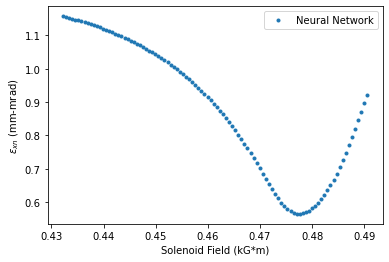

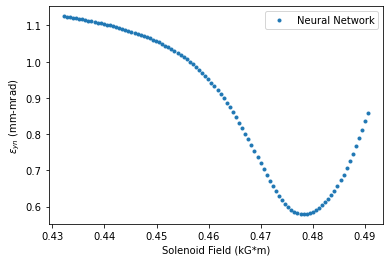

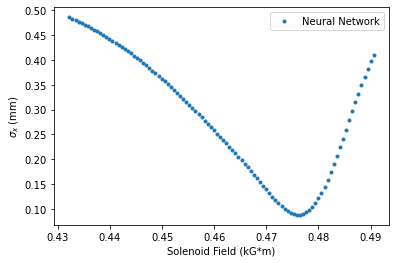

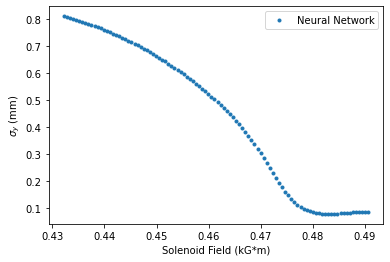

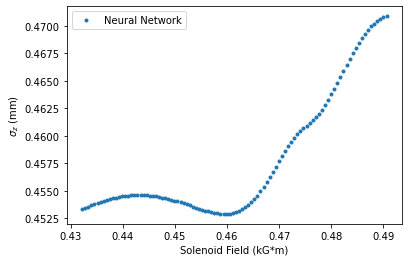

 
SQ01:b1_gradient
 


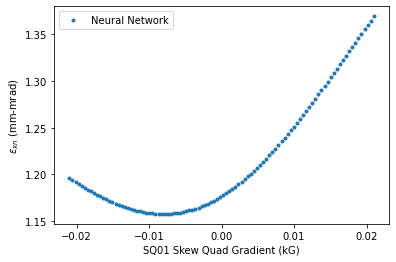

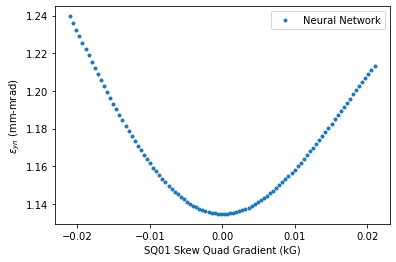

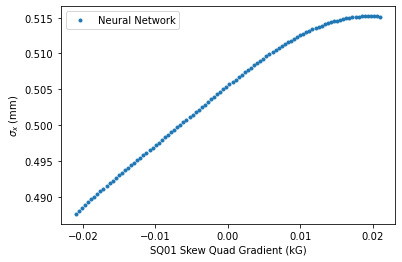

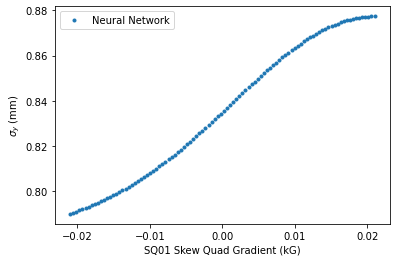

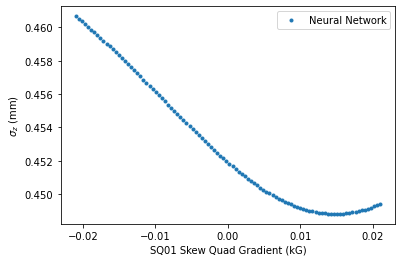

 
CQ01:b1_gradient
 


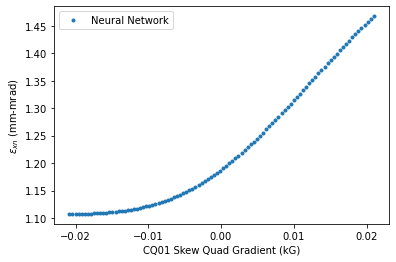

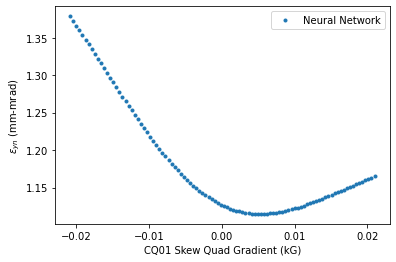

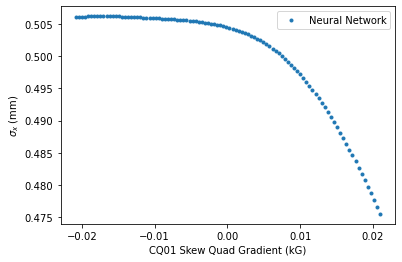

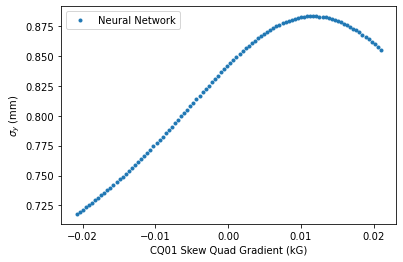

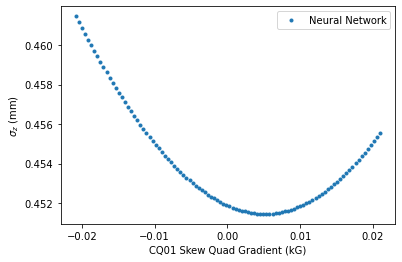

In [112]:
X_scan1,Y_pred1, X_scan2,Y_pred2, X_scan3,Y_pred3 = do_scan_at_measured(inputs = ref_input_values);

 
SOL1:solenoid_field_scale
 


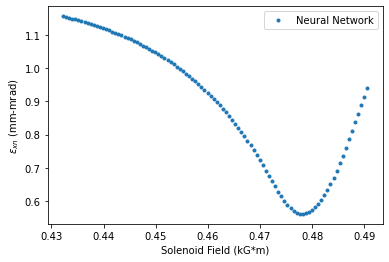

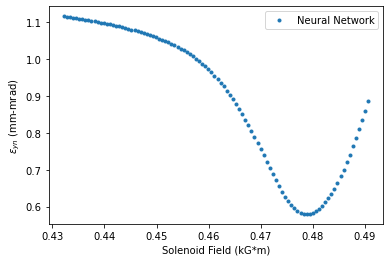

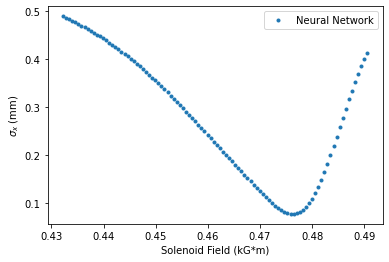

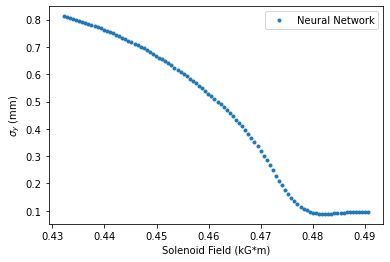

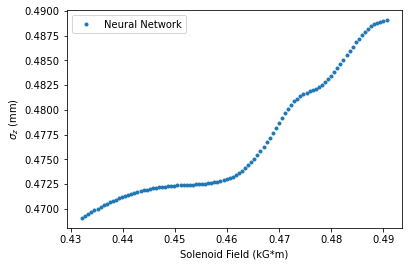

 
SQ01:b1_gradient
 


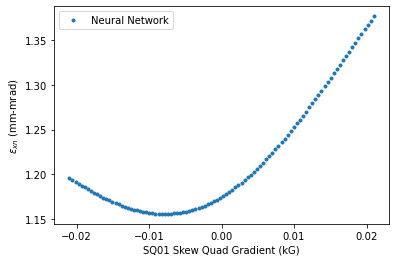

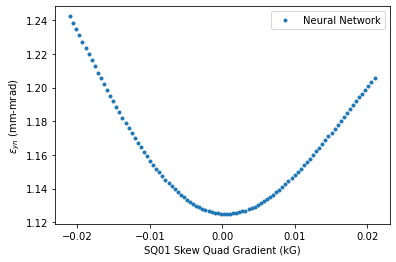

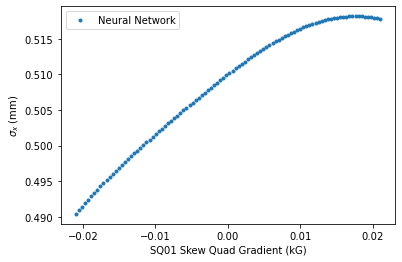

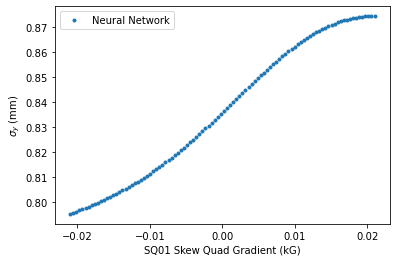

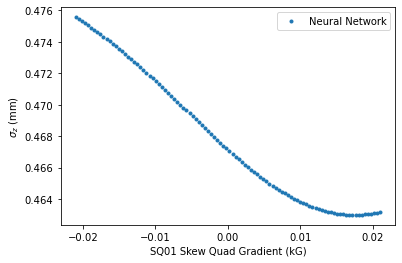

 
CQ01:b1_gradient
 


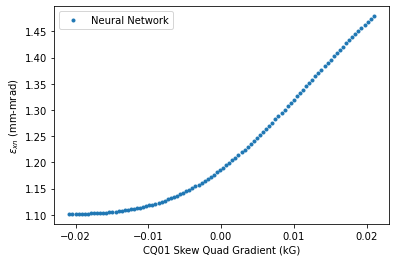

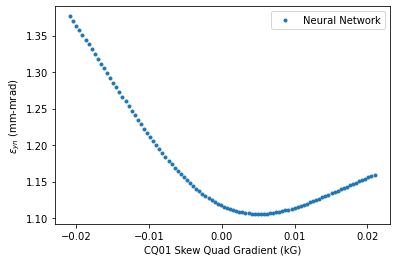

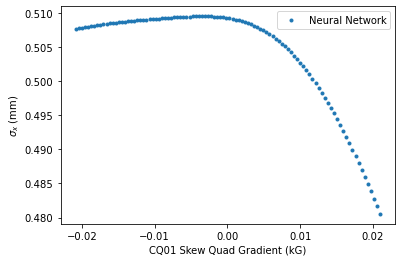

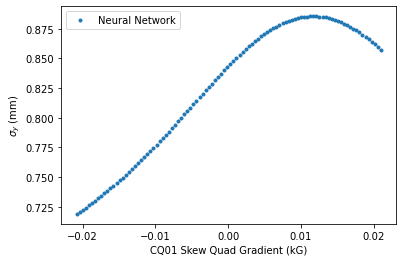

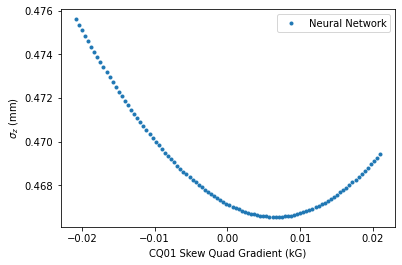

In [113]:
X_scan1m,Y_pred1m, X_scan2m,Y_pred2m, X_scan3m,Y_pred3m = do_scan_at_measured(inputs = md_values);

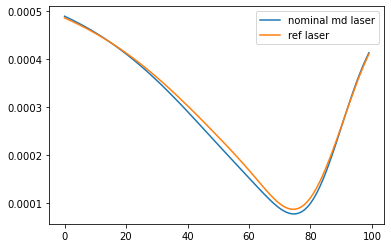

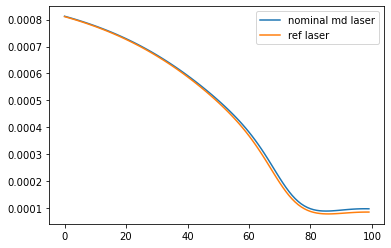

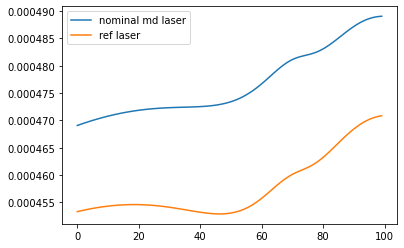

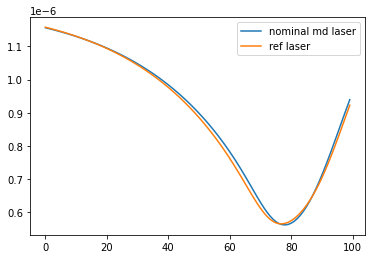

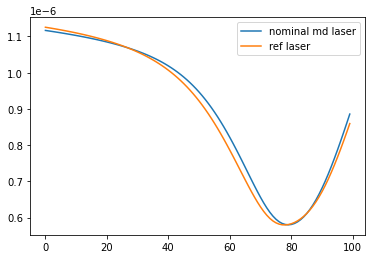

In [114]:
for i in range(0,len(model_out_list)):
    plt.plot(Y_pred1m[:,i])
    plt.plot(Y_pred1[:,i])
    plt.legend(['nominal md laser','ref laser'])
    plt.show()

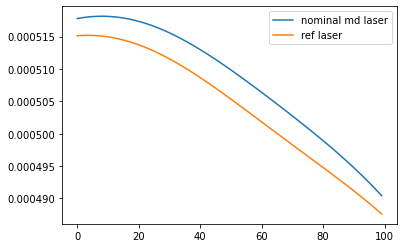

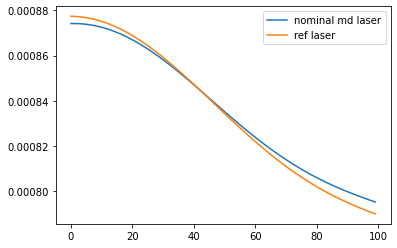

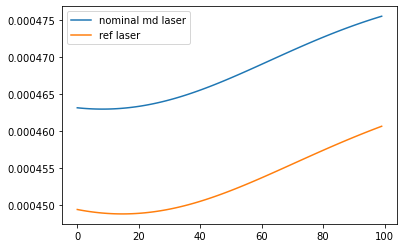

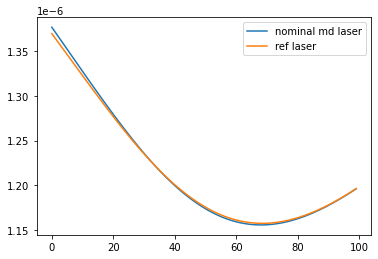

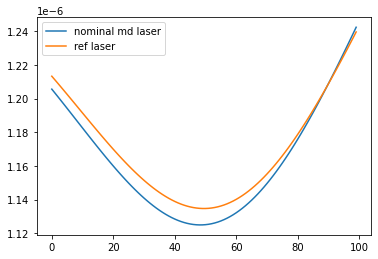

In [115]:
for i in range(0,len(model_out_list)):
    plt.plot(Y_pred2m[:,i])
    plt.plot(Y_pred2[:,i])
    plt.legend(['nominal md laser','ref laser'])
    plt.show()

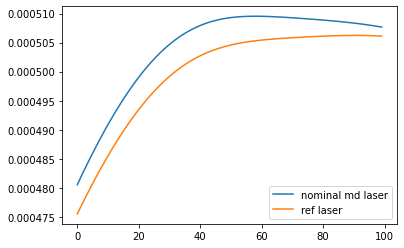

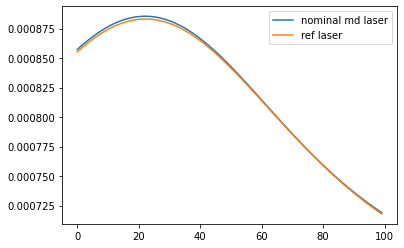

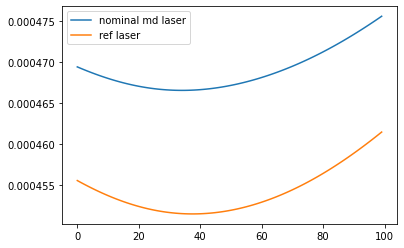

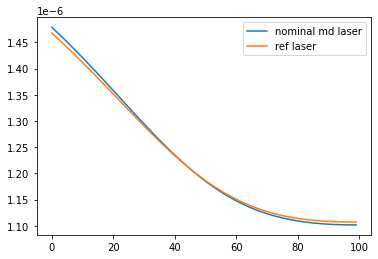

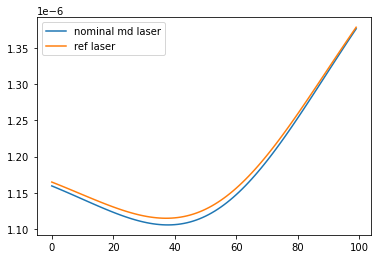

In [116]:
for i in range(0,len(model_out_list)):
    plt.plot(Y_pred3m[:,i])
    plt.plot(Y_pred3[:,i])
    plt.legend(['nominal md laser','ref laser'])
    plt.show()

<a id="hess_start"></a>

# Check Hessian at Simulation Optimum and Calculate Correlated Kernel

In [117]:
import numdifftools as nd
from numdifftools import Hessian

### Steps for Hessian (Joe/Adi please comment:)

for each calc in Hessian op:
1. Full scale machine units
2. Convert to sim units
3. Scale down to NN scale (0.01 to 1)
4. Predict model output
5. Scale back to full scale sim + machine units (these are the same)
6. Normalize (0,1) for pedestal and fheight, then subtract these, then multiply by -1 (want to minimize np.sqrt(emitx * emity))



Q1: SCALING OF OBJECTIiVE np.sqrt(emitx * emity) --> what unit of emittance values?

Q2: Step size for hessian approx

Q3: Expansion doesn't look right, see below


<a id="hess_sim"></a>

# Calc with Sim Units 

In [223]:


def calc_obj(y):
    yobj = np.copy(y)
    yobj= np.sqrt(y[:,loc_out['norm_emit_x']]*y[:,loc_out['norm_emit_y']])  #SCALING OF OBJECTIiVE?
    return yobj

def get_ped_and_fheight(xin,xloc, machine_units=False):
    
    
    y=model_pred(xin) 
    
    if machine_units:
        y=model_pred_machine_units(xin) 
        
    
    #get objective value
    yobj = calc_obj(y)
    
    
    plt.plot(yobj)
    plt.show()
    
    #negate
    yobj = -1.0*yobj
    
    #subtract pedestal
    pedestal = np.min(yobj)
    print('ped 1: ',pedestal)
    #pedestal = np.percentile(y,30)
    #print('ped 2: ',pedestal)
    yobj = yobj - pedestal
    
    #scale to height
    fheight = np.max(yobj)
    print(fheight)
    yobj = yobj/fheight 
    
    plt.plot(yobj)
    plt.ylabel('Objective)',fontsize=12)
    plt.xlabel('Sample',fontsize=12)
    plt.tight_layout()
    print('pedestal:', pedestal, 'fheight:', fheight)
    plt.show()
    return yobj, pedestal, fheight

#def spec_ped_and_fheight(xin,pedestal,fheight,xloc):
#   y=model_pred_machine_units(xin)
#    
#    #get objective value
#    y = calc_obj(y)
#    
#    #negate
#    y = -1.0*y
#    
#    #subtract pedestal
#    y = y - pedestal
    
#    #scale to height
#    y = y/fheight 
#    plt.plot(xin[:,xloc],y)
#    plt.show()
#    return y


 #takes full, machine unit scale xin and predicts full machine unit scale y
def get_mdl_out_for_hessian(x_h_in):
    
    xin=np.copy(x_to_eval)
    
    print('x_h_in',x_h_in)
    
    xin[:,loc_in['SOL1:solenoid_field_scale']]=np.copy(x_h_in[0])
    xin[:,loc_in['CQ01:b1_gradient']]=np.copy(x_h_in[1])
    xin[:,loc_in['SQ01:b1_gradient']]=np.copy(x_h_in[2])

    
    y=model_pred(xin)
    
    if machine_units:
        y=model_pred_machine_units(xin) 
    
    print('raw pred',y)
    
    #get objective value
    yobj = calc_obj(y)
    
    print('yobj_raw',yobj)
    

    #negate
    yobj = -1.0*yobj
    
    #subtract pedestal
    yobj = yobj - pedestal
    
    #scale to height
    yobj = yobj/fheight 
    
    print('-yobj scaled',-yobj)
    

    return -yobj

def get_hessian(x_to_eval):
    
    x_h_in=[x_to_eval[:,loc_in['SOL1:solenoid_field_scale']][0],x_to_eval[:,loc_in['CQ01:b1_gradient']][0],x_to_eval[:,loc_in['SQ01:b1_gradient']][0]]
    print('foo1',x_h_in)
    
    hess = nd.Hessian(get_mdl_out_for_hessian)(x_h_in)

    return hess

## walking through steps first to verify

In [355]:
numscan=100
scan=np.linspace(0.2,0.26,numscan) # simulation scale
x_scan=np.empty((numscan,len(model_in_list)))
x_scan[:,:]=np.copy(md_values)
x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan

In [356]:
y=model_pred(x_scan)
yobj=calc_obj(y)

In [357]:
xmax_id = np.argmax(-yobj)
xmax = x_scan[xmax_id,:]

In [358]:
xmax_id

76

In [367]:
xmax

array([ 3.99999960e-01,  3.30000000e+00,  2.50000000e+02,  2.46060606e-01,
        7.13917676e-04,  3.27285211e-04,  5.80000000e+07, -9.53597349e+00,
        7.00000000e+07,  9.85566222e+00])

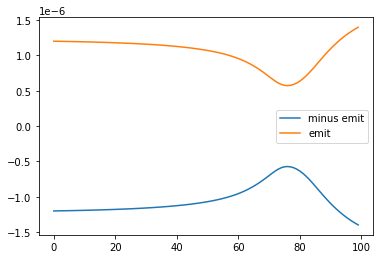

In [364]:
plt.plot(-yobj)
plt.plot(np.sqrt(y[:,loc_out['norm_emit_x']]*y[:,loc_out['norm_emit_y']]))
plt.legend(['minus emit','emit'])

ped 1:  -1.3954773e-06
8.2439766e-07
pedestal: -1.3954773e-06 fheight: 8.2439766e-07


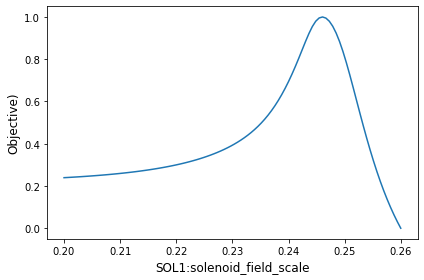

In [365]:

#negate
y = -1.0*yobj

#subtract pedestal
pedestal = np.min(y)
print('ped 1: ',pedestal)
#pedestal = np.percentile(y,30)
#print('ped 2: ',pedestal)
y = y - pedestal

#scale to height
fheight = np.max(y)
print(fheight)
y = y/fheight 

plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],y)
plt.ylabel('Objective)',fontsize=12)
plt.xlabel('SOL1:solenoid_field_scale',fontsize=12)
plt.tight_layout()
print('pedestal:', pedestal, 'fheight:', fheight)
plt.show()

## get pedestal and fheight

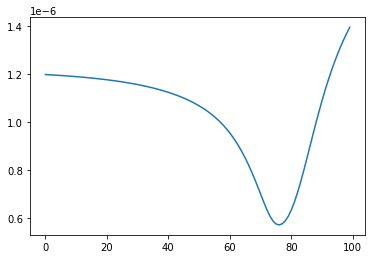

ped 1:  -1.3954773e-06
8.2439766e-07
pedestal: -1.3954773e-06 fheight: 8.2439766e-07


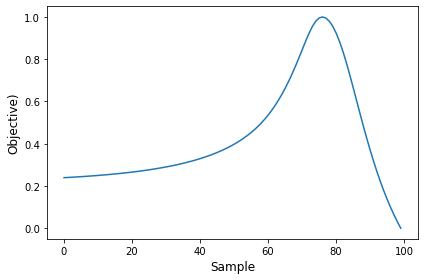

In [368]:
# ped and fheight
y,pedestal,fheight=get_ped_and_fheight(x_scan, loc_in['SOL1:solenoid_field_scale'])

## do Hessian calc

In [369]:
#calc Hessian at x 
machine_units=False
x_to_eval=xmax.reshape(1,10)#np.copy(md_values) #simulation scale
hess_at_max = get_hessian(x_to_eval);

foo1 [0.24606060606060606, 0.0007139176759844664, 0.0003272852109147791]
x_h_in [0.24606061 0.00071392 0.00032729]
raw pred [[8.86363123e-05 1.04828876e-04 4.82641626e-04 5.61812612e-07
  5.80499488e-07]]
yobj_raw [5.710796e-07]
-yobj scaled [-1.]
x_h_in [4.24606061e+00 7.13917676e-04 3.27285211e-04]
raw pred [[2.5180113e-04 5.0060466e-05 7.5470633e-04 1.9054876e-06 2.5828792e-06]]
yobj_raw [2.218478e-06]
-yobj scaled [0.9983054]
x_h_in [-3.75393939e+00  7.13917676e-04  3.27285211e-04]
raw pred [[6.1193394e-04 9.3238510e-04 3.7352409e-04 1.1541275e-06 1.2721060e-06]]
yobj_raw [1.2116817e-06]
-yobj scaled [-0.22294529]
x_h_in [2.24606061e+00 2.00071392e+00 3.27285211e-04]
raw pred [[2.8904763e-04 5.0962553e-05 4.6823910e-04 2.8616219e-06 3.5231160e-06]]
yobj_raw [3.175189e-06]
-yobj scaled [2.1588025]
x_h_in [ 2.24606061e+00 -1.99928608e+00  3.27285211e-04]
raw pred [[8.2556898e-04 5.3719592e-05 4.7240368e-04 2.5579884e-06 2.7500535e-06]]
yobj_raw [2.652283e-06]
-yobj scaled [1.524514]


In [370]:
hess_at_max_sim_units = np.copy(hess_at_max)
np.save('hess_at_max_sim_units.npy',hess_at_max_sim_units)

## Check Expansion

In [ ]:
#ymax*e^-hess_at_max(0,0)(x-xmax)**2

In [371]:
numscan=100
scan=np.linspace(0.2,0.26,numscan) # simulation scale
x_scan=np.empty((numscan,len(model_in_list)))
x_scan[:,:]=np.copy(md_values)
x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan

In [372]:
y=model_pred(x_scan)

y=calc_obj(y)

plot_for_exp=(-1*y -pedestal)/fheight

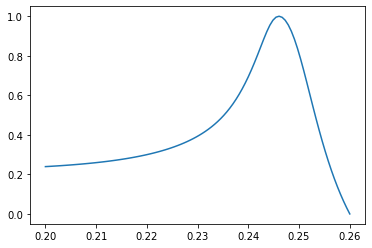

In [373]:
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],plot_for_exp)

In [375]:
hess_at_max_sim_units

array([[-0.04287797,  0.02527132,  0.00898357],
       [ 0.02527132, -0.11187614, -0.36310077],
       [ 0.00898357, -0.36310077,  0.05403811]])

In [343]:
x_scan[:,loc_in['SOL1:solenoid_field_scale']]

array([0.2       , 0.20060606, 0.20121212, 0.20181818, 0.20242424,
       0.2030303 , 0.20363636, 0.20424242, 0.20484848, 0.20545455,
       0.20606061, 0.20666667, 0.20727273, 0.20787879, 0.20848485,
       0.20909091, 0.20969697, 0.21030303, 0.21090909, 0.21151515,
       0.21212121, 0.21272727, 0.21333333, 0.21393939, 0.21454545,
       0.21515152, 0.21575758, 0.21636364, 0.2169697 , 0.21757576,
       0.21818182, 0.21878788, 0.21939394, 0.22      , 0.22060606,
       0.22121212, 0.22181818, 0.22242424, 0.2230303 , 0.22363636,
       0.22424242, 0.22484848, 0.22545455, 0.22606061, 0.22666667,
       0.22727273, 0.22787879, 0.22848485, 0.22909091, 0.22969697,
       0.23030303, 0.23090909, 0.23151515, 0.23212121, 0.23272727,
       0.23333333, 0.23393939, 0.23454545, 0.23515152, 0.23575758,
       0.23636364, 0.2369697 , 0.23757576, 0.23818182, 0.23878788,
       0.23939394, 0.24      , 0.24060606, 0.24121212, 0.24181818,
       0.24242424, 0.2430303 , 0.24363636, 0.24424242, 0.24484

In [376]:
np.asarray(md_values)[:,loc_in['SOL1:solenoid_field_scale']]

array([0.22])

In [377]:
hess_at_max_sim_units

array([[-0.04287797,  0.02527132,  0.00898357],
       [ 0.02527132, -0.11187614, -0.36310077],
       [ 0.00898357, -0.36310077,  0.05403811]])

In [378]:
xmax

array([ 3.99999960e-01,  3.30000000e+00,  2.50000000e+02,  2.46060606e-01,
        7.13917676e-04,  3.27285211e-04,  5.80000000e+07, -9.53597349e+00,
        7.00000000e+07,  9.85566222e+00])

In [384]:
expansion=np.max(plot_for_exp)*np.exp(-0.5*hess_at_max_sim_units[0,0]*(x_scan[:,loc_in['SOL1:solenoid_field_scale']]-xmax.reshape(1,10)[:,loc_in['SOL1:solenoid_field_scale']])**2)

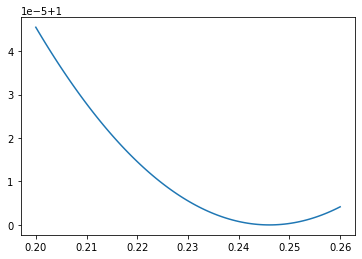

In [385]:
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],expansion);


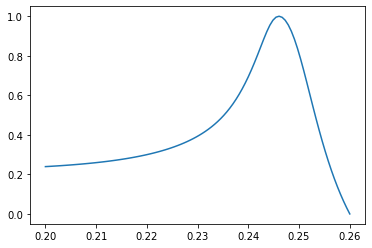

In [386]:
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],plot_for_exp);

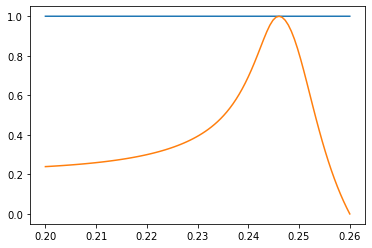

In [350]:
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],expansion);
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],(-y-pedestal)/fheight);

In [244]:
!pwd

/gpfs/slac/staas/fs1/g/accelerator_modeling/edelen/LCLS_CU_full/training/OTR2/packaged/lcls_cu_injector_tuning/models/simple_models



<a id="hess_machine"></a>

# Calc with Machine Units

In [388]:
numscan=100
scan=np.linspace(0.4,0.5,numscan) # simulation scale
x_scan=np.empty((numscan,len(model_in_list)))
x_scan[:,:]=np.copy(md_values_machine_scale)
x_scan[:,loc_in['SOL1:solenoid_field_scale']]=scan

y=model_pred_machine_units(x_scan)
yobj=calc_obj(y)

In [389]:
xmax_id = np.argmax(-yobj)
xmax = x_scan[xmax_id,:]

In [390]:
xmax_id

78

In [391]:
xmax

array([ 1.20000000e+00,  2.00000000e+00,  2.50000000e+02,  4.78787879e-01,
       -1.49922712e-03, -6.87298943e-04,  5.80000000e+01, -9.53597349e+00,
        7.00000000e+01,  9.85566222e+00])

In [392]:
#calc Hessian at x 
machine_units=True
x_to_eval=xmax.reshape(1,10)#np.copy(md_values_machine_scale) #machine scale
hess_at_max = get_hessian(x_to_eval);

foo1 [0.47878787878787876, -0.0014992271201670704, -0.0006872989431959557]
x_h_in [ 0.47878788 -0.00149923 -0.0006873 ]
raw pred [[9.2129660e-05 1.0169427e-04 4.8278683e-04 5.6291901e-07 5.8020009e-07]]
yobj_raw [5.7149424e-07]
-yobj scaled [-0.99949706]
x_h_in [ 4.47878788e+00 -1.49922712e-03 -6.87298943e-04]
raw pred [[2.5644319e-04 5.0874223e-05 7.5033546e-04 1.9220010e-06 2.5964923e-06]]
yobj_raw [2.233934e-06]
-yobj scaled [1.0170538]
x_h_in [-3.52121212e+00 -1.49922712e-03 -6.87298943e-04]
raw pred [[6.0968345e-04 9.1969769e-04 3.7486444e-04 1.1515000e-06 1.2842370e-06]]
yobj_raw [1.2160588e-06]
-yobj scaled [-0.2176359]
x_h_in [ 2.47878788e+00  1.99850077e+00 -6.87298943e-04]
raw pred [[8.1826211e-04 5.4382326e-05 4.7316047e-04 2.5722725e-06 2.8163270e-06]]
yobj_raw [2.691535e-06]
-yobj scaled [1.5721269]
x_h_in [ 2.47878788e+00 -2.00149923e+00 -6.87298943e-04]
raw pred [[2.8629953e-04 5.0377610e-05 4.6848136e-04 2.8512920e-06 3.5039830e-06]]
yobj_raw [3.1608351e-06]
-yobj scale

In [393]:
hess_at_max_machine = np.copy(hess_at_max)
np.save('hess_at_max_machine_units.npy',hess_at_max_machine)

## Check Expansion for Measured Units

In [247]:
#ymax*e^-hess_at_max(0,0)(x-xmax)**2

In [394]:


plot_for_exp=(-1*yobj -pedestal)/fheight

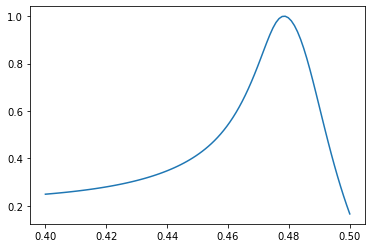

In [395]:
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],plot_for_exp)

In [397]:
x_scan[:,loc_in['SOL1:solenoid_field_scale']]

array([0.4       , 0.4010101 , 0.4020202 , 0.4030303 , 0.4040404 ,
       0.40505051, 0.40606061, 0.40707071, 0.40808081, 0.40909091,
       0.41010101, 0.41111111, 0.41212121, 0.41313131, 0.41414141,
       0.41515152, 0.41616162, 0.41717172, 0.41818182, 0.41919192,
       0.42020202, 0.42121212, 0.42222222, 0.42323232, 0.42424242,
       0.42525253, 0.42626263, 0.42727273, 0.42828283, 0.42929293,
       0.43030303, 0.43131313, 0.43232323, 0.43333333, 0.43434343,
       0.43535354, 0.43636364, 0.43737374, 0.43838384, 0.43939394,
       0.44040404, 0.44141414, 0.44242424, 0.44343434, 0.44444444,
       0.44545455, 0.44646465, 0.44747475, 0.44848485, 0.44949495,
       0.45050505, 0.45151515, 0.45252525, 0.45353535, 0.45454545,
       0.45555556, 0.45656566, 0.45757576, 0.45858586, 0.45959596,
       0.46060606, 0.46161616, 0.46262626, 0.46363636, 0.46464646,
       0.46565657, 0.46666667, 0.46767677, 0.46868687, 0.46969697,
       0.47070707, 0.47171717, 0.47272727, 0.47373737, 0.47474

In [399]:
xmax

array([ 1.20000000e+00,  2.00000000e+00,  2.50000000e+02,  4.78787879e-01,
       -1.49922712e-03, -6.87298943e-04,  5.80000000e+01, -9.53597349e+00,
        7.00000000e+01,  9.85566222e+00])

In [400]:
hess_at_max_machine

array([[-0.04864794, -0.02577206, -0.02722063],
       [-0.02577206,  0.35310496, -0.49935353],
       [-0.02722063, -0.49935353, -0.00379887]])

In [401]:
expansion=np.max(plot_for_exp)*np.exp(-0.5*hess_at_max_machine[0,0]*(x_scan[:,loc_in['SOL1:solenoid_field_scale']]-xmax.reshape(1,10)[:,loc_in['SOL1:solenoid_field_scale']])**2)

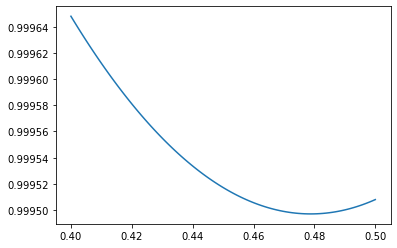

In [402]:
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],expansion);


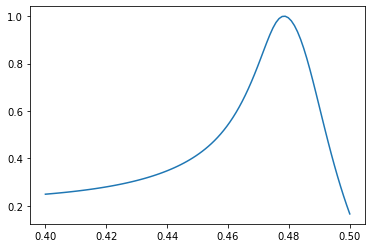

In [403]:
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],plot_for_exp);

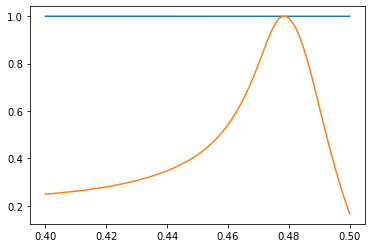

In [405]:
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],expansion);
plt.plot(x_scan[:,loc_in['SOL1:solenoid_field_scale']],(-yobj-pedestal)/fheight);

## Compare to saved versions

In [ ]:
#np.set_printoptions(linewidth=160)
#nolog = np.load('hess_at_max_nolog.npy')
#withlog = np.load('hess_at_max_log.npy')

In [ ]:
#for i in range(0,13):
#    print('row_' + str(i) +'_new: ', np.round(hess_at_max[i,:],3))
#    print('row_' + str(i) +'_log: ', np.round(withlog[i,:],3))
#    print('row_' + str(i) +'_no_log: ', np.round(nolog[i,:],3))
#    print('--------------------------------------------------')